# Modèle LGD

In [1]:
import numpy as np
import pandas as pd

In [3]:
datos_preprocesados_respaldo = pd.read_csv('C:/Users/IDEAPAD5/Desktop/Python Udemy/Model LGD/datos_preprocesados.csv', index_col=0)

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\1458827369.py:1: DtypeWarning: Columns (19,47) have mixed types. Specify dtype option on import or set low_memory=False.
  datos_preprocesados_respaldo = pd.read_csv('C:/Users/IDEAPAD5/Desktop/Python Udemy/Model LGD/datos_preprocesados.csv', index_col=0)


In [4]:
datos_preprocesados = datos_preprocesados_respaldo

In [5]:
# Exploration des données

In [6]:
datos_preprocesados.head()

member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
id                                                                        
1077501    1296599       5000         5000           4975.0   36 months   
1077430    1314167       2500         2500           2500.0   60 months   
1077175    1313524       2400         2400           2400.0   36 months   
1076863    1277178      10000        10000          10000.0   36 months   
1075358    1311748       3000         3000           3000.0   60 months   

         int_rate  installment grade sub_grade                 emp_title  ...  \
id                                                                        ...   
1077501     10.65       162.87     B        B2                       NaN  ...   
1077430     15.27        59.83     C        C4                     Ryder  ...   
1077175     15.96        84.33     C        C5                       NaN  ...   
1076863     13.49       339.31     C        C1       AIR RESOURCES BOARD  ...   
1075358     12.69        67.79     B        B5  University Medical Group  ...   

        Subgrado_F2 Subgrado_F3  Subgrado_F4 Subgrado_F5 Subgrado_G1  \
id                                                                     
1077501           0           0            0           0           0   
1077430           0           0            0           0           0   
1077175           0           0            0           0           0   
1076863           0           0            0           0           0   
1075358           0           0            0           0           0   

        Subgrado_G2 Subgrado_G3 Subgrado_G4 Subgrado_G5 buenos_malos  
id                                                                    
1077501           0           0           0           0            1  
1077430           0           0           0           0            0  
1077175           0           0           0           0            1  
1076863           0           0           0           0            1  
1075358           0           0           0           0            1  

[5 rows x 206 columns]

Établissons les défauts
Pour le modèle LGD, nous avons besoin du pourcentage d'exposition qui a été perdu après que le client
ait fait défaut. Ces données sont disponibles dans notre base de données.
Il ne serait pas correct d'inclure toutes les observations que nous définissons comme "défaut" dans le modèle PD
parce qu'il est possible que certains clients qui ont fait défaut "temporairement" ont commencé
à rembourser lorsque leur situation s'est améliorée. C'est pourquoi, dans les modèles LGD et EAD
(Exposition au Défaut), nous n'inclurons que les clients qui ont eu suffisamment de temps pour rembourser
et ne l'ont pas fait. Autrement dit, nous inclurons uniquement les clients qui ont été radiés ou
"written off" en anglais. C'est-à-dire, ceux inclus dans les catégories :
'Charged Off'
'Does not meet the credit policy. Status: Charged Off

In [8]:
datos_preprocesados['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off'],
      dtype=object)

In [9]:
datos_defaults = datos_preprocesados[datos_preprocesados['loan_status'].isin(['Charged Off',
                                                                              'Does not meet the credit policy. Status:Charged Off'])]

In [10]:
datos_defaults.shape

(43236, 206)

In [11]:
datos_preprocesados.shape

(466285, 206)

# Variables Independientes

Les variables indépendantes que nous utiliserons pour les modèles LGD et EAD sont les mêmes que
celles que nous avons utilisées pour le modèle PD. Rappelons-nous que lors de la construction du modèle PD, nous avons ignoré certaines
variables. Vérifions s'il y a toujours des données manquantes dans les variables que nous souhaitons utiliser.

In [13]:
pd.options.display.max_rows = None

In [14]:
# sommes des nulls

In [15]:
datos_defaults.isnull().sum()

member_id                                                                 0
loan_amnt                                                                 0
funded_amnt                                                               0
funded_amnt_inv                                                           0
term                                                                      0
int_rate                                                                  0
installment                                                               0
grade                                                                     0
sub_grade                                                                 0
emp_title                                                              3287
emp_length                                                             2337
home_ownership                                                            0
annual_inc                                                                0
verification

Les variables indépendantes dans les modèles LGD et EAD ne doivent pas nécessairement être binaires (dummies).
Nous avons construit le modèle PD de la manière la plus facile à comprendre car c'est une exigence du régulateur.
Les résultats du modèle PD (la grille de score) sont accessibles au public pour les clients ou les clients potentiels.
En revanche, les modèles LGD et EAD sont destinés à un usage interne par l'institution financière, et par conséquent,
il n'est pas nécessaire qu'ils soient simples et faciles à interpréter pour tous. Pour cette raison,
pour les variables discrètes des modèles LGD et EAD, nous créerons autant de dummies que de catégories dans
la variable. De plus, nous pouvons utiliser les variables continues sans nécessité de classification fine ou grossière.

Nous pouvons inclure les variables "mths..." que nous venons de mentionner comme variables continues sans
besoin de les classer. Cependant, nous devons traiter les données manquantes de ces variables.
Lorsque nous n'avons pas plus d'informations, l'approche la plus conservatrice en ce qui concerne le risque est idéale.
Dans ce cas, ce serait de mettre 0 mois.

In [18]:
datos_defaults['mths_since_last_delinq'].fillna(0, inplace = True)

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\2685258781.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['mths_since_last_delinq'].fillna(0, inplace = True)


In [21]:
# Mettons des zéros dans les données manquantes de mths_since_last_record 

In [22]:
datos_defaults['mths_since_last_record'].fillna(0, inplace = True)

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\2237890873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['mths_since_last_record'].fillna(0, inplace = True)


In [25]:
# Vérifions qu'il n'y ait pas de données manquantes

In [26]:
datos_defaults.isnull().sum()

member_id                                                                 0
loan_amnt                                                                 0
funded_amnt                                                               0
funded_amnt_inv                                                           0
term                                                                      0
int_rate                                                                  0
installment                                                               0
grade                                                                     0
sub_grade                                                                 0
emp_title                                                              3287
emp_length                                                             2337
home_ownership                                                            0
annual_inc                                                                0
verification

# Variable dépendante du modèle LGD : Taux de Récupération

In [27]:
#Nous pouvons trouver le montant récupéré après le défaut dans la colonne 'recoveries'
#Nous supposerons que la colonne 'funded_amnt' reflète le montant total perdu lorsque l'emprunteur a fait défaut.
#Nous pouvons calculer le Taux de Récupération = recoveries / funded amount

In [28]:
datos_defaults['tasa_recuperacion'] = datos_defaults['recoveries'] / datos_defaults['funded_amnt']

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\2851705466.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['tasa_recuperacion'] = datos_defaults['recoveries'] / datos_defaults['funded_amnt']


In [29]:
# description 'tasa_recuperacion'

In [30]:
datos_defaults['tasa_recuperacion'].describe()

count    43236.000000
mean         0.060820
std          0.089770
min          0.000000
25%          0.000000
50%          0.029466
75%          0.114044
max          1.220774
Name: tasa_recuperacion, dtype: float64

Alors que c'est un taux, nous nous attendions à un nombre entre 0 et 1.
Les données réelles ne sont pas parfaites ! Il peut y avoir des divergences en raison de facteurs comptables ou, dans
un cas très particulier, imaginez que lors de la liquidation de la garantie et après déduction de tous les coûts associés,
la banque a obtenu plus d'argent que ce qui lui était dû...
Pour rester cohérents avec le modèle, dans ces cas, nous allons tronquer les données pour qu'elles soient dans la plage
entre 0 et 1.

In [31]:
datos_defaults['tasa_recuperacion'] = np.where(datos_defaults['tasa_recuperacion'] > 1, 1, datos_defaults['tasa_recuperacion'])

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\3317527587.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['tasa_recuperacion'] = np.where(datos_defaults['tasa_recuperacion'] > 1, 1, datos_defaults['tasa_recuperacion'])


In [32]:
datos_defaults['tasa_recuperacion'] = np.where(datos_defaults['tasa_recuperacion'] < 0, 0, datos_defaults['tasa_recuperacion'])

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\4125690315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['tasa_recuperacion'] = np.where(datos_defaults['tasa_recuperacion'] < 0, 0, datos_defaults['tasa_recuperacion'])


In [ ]:
datos_defaults['tasa_recuperacion'].describe()

# Variable dépendante du modèle EAD : Facteur de conversion de crédit

Avec les données que nous avons dans la base, nous pouvons estimer le facteur de conversion de crédit. La colonne 'total_rec_prncp' représente le total des paiements effectués ou crédités au capital du prêt. En cas de défaut de l'emprunteur, celui-ci devrait rembourser le montant emprunté (funded amount) moins les paiements effectués au capital.

Ainsi, le facteur de conversion de crédit (FCC) serait égal à la proportion du montant emprunté (funded_amnt) que l'emprunteur doit encore rembourser : (funded_amnt - total_rec_prncp) / funded_amnt

In [36]:
datos_defaults['FCC'] = (datos_defaults['funded_amnt'] - datos_defaults['total_rec_prncp']) / datos_defaults['funded_amnt']

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\2872504495.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['FCC'] = (datos_defaults['funded_amnt'] - datos_defaults['total_rec_prncp']) / datos_defaults['funded_amnt']


In [37]:
# description de FCC

In [38]:
datos_defaults['FCC'].describe()

count    43236.000000
mean         0.735952
std          0.200742
min          0.000438
25%          0.632088
50%          0.789908
75%          0.888543
max          1.000000
Name: FCC, dtype: float64

Nous constatons que le FCC est un taux compris entre 0 et 1. Lorsque le FCC est zéro, cela signifie que le capital récupéré est égal au montant accordé, c'est-à-dire que le crédit a été entièrement remboursé. Si le FCC est égal à un, cela signifie que le capital récupéré est nul, c'est-à-dire que rien du crédit n'a été remboursé, et le montant total est dû.

In [266]:
# Export to *.csv

In [42]:
datos_defaults.to_csv('datos_defaults.csv')

# Explorando las variables dependientes

Comme nous l'avons vu lors des sessions précédentes, les variables dépendantes pour les modèles LGD et EAD, c'est-à-dire
le taux de récupération et le facteur de conversion de crédit respectivement, sont restreintes à l'intervalle de 0 à 1. Explorons visuellement

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [43]:
# histograma taux de récuperation

(array([2.1023e+04, 1.8370e+03, 3.8730e+03, 1.3940e+03, 2.1330e+03,
        3.3440e+03, 4.7650e+03, 1.7130e+03, 1.1790e+03, 4.0600e+02,
        3.4100e+02, 2.7400e+02, 1.1700e+02, 9.3000e+01, 8.1000e+01,
        7.3000e+01, 5.4000e+01, 7.2000e+01, 5.7000e+01, 3.0000e+01,
        4.7000e+01, 2.7000e+01, 1.7000e+01, 1.5000e+01, 2.0000e+01,
        2.3000e+01, 1.7000e+01, 7.0000e+00, 1.1000e+01, 7.0000e+00,
        8.0000e+00, 7.0000e+00, 7.0000e+00, 8.0000e+00, 7.0000e+00,
        1.0000e+01, 6.0000e+00, 1.1000e+01, 9.0000e+00, 9.0000e+00,
        6.0000e+00, 6.0000e+00, 6.0000e+00, 3.0000e+00, 9.0000e+00,
        9.0000e+00, 1.5000e+01, 8.0000e+00, 9.0000e+00, 3.3000e+01]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.

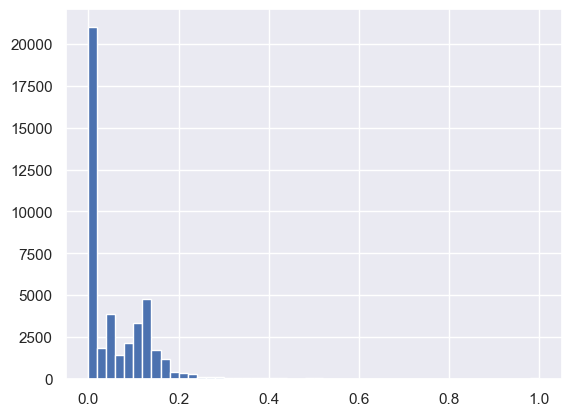

In [44]:
plt.hist(datos_defaults['tasa_recuperacion'], bins = 50)

In [45]:
# histo Factor de Convertion de Crédit FCC

(array([  20.,   60.,   29.,   97.,   70.,   84.,  150.,   78.,  124.,
         170.,  152.,  208.,  199.,  228.,  242.,  276.,  300.,  335.,
         339.,  376.,  412.,  421.,  505.,  505.,  575.,  583.,  614.,
         735.,  756.,  812.,  840.,  942.,  959., 1137., 1217., 1418.,
        1431., 1580., 1732., 1850., 2003., 2151., 2123., 2376., 2447.,
        2693., 2366., 2115., 1527.,  874.]),
 array([4.3800000e-04, 2.0429240e-02, 4.0420480e-02, 6.0411720e-02,
        8.0402960e-02, 1.0039420e-01, 1.2038544e-01, 1.4037668e-01,
        1.6036792e-01, 1.8035916e-01, 2.0035040e-01, 2.2034164e-01,
        2.4033288e-01, 2.6032412e-01, 2.8031536e-01, 3.0030660e-01,
        3.2029784e-01, 3.4028908e-01, 3.6028032e-01, 3.8027156e-01,
        4.0026280e-01, 4.2025404e-01, 4.4024528e-01, 4.6023652e-01,
        4.8022776e-01, 5.0021900e-01, 5.2021024e-01, 5.4020148e-01,
        5.6019272e-01, 5.8018396e-01, 6.0017520e-01, 6.2016644e-01,
        6.4015768e-01, 6.6014892e-01, 6.8014016e-01, 7.0

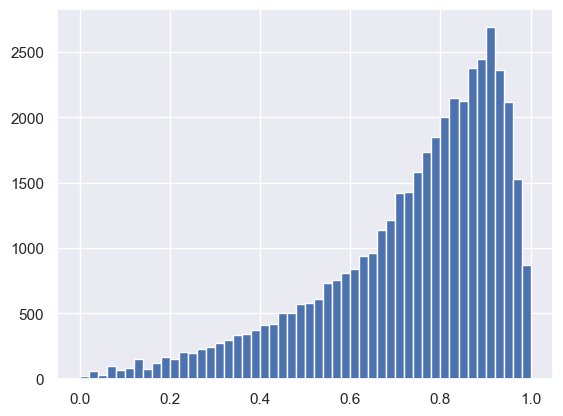

In [46]:
plt.hist(datos_defaults['FCC'], bins = 50)

# Préparation des variables pour le modèle LGD

Rappelons que le modèle LGD sera composé de deux étapes :
LGD0 : Nous allons déterminer si le taux de récupération est zéro ou différent de zéro avec une régression logistique
LGD1 : Pour les observations qui sont différentes de zéro, nous prédirons le taux de récupération avec une régression linéaire

In [96]:
#Générer la variable dépendante pour la première étape (LGD0)
#Nous désignerons cette variable binaire comme "tasa_recuperacion_0" :
#elle prendra la valeur de 1 si le taux de récupération est zéro, et 0 pour toute autre valeur.

In [97]:
datos_defaults['tasa_recuperacion_0'] = np.where(datos_defaults['tasa_recuperacion'] == 0, 1, 0)

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\239130532.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_defaults['tasa_recuperacion_0'] = np.where(datos_defaults['tasa_recuperacion'] == 0, 1, 0)


In [98]:
datos_defaults['tasa_recuperacion_0']

id
1077430     0
1071795     0
1071570     0
1064687     0
1069057     0
1039153     1
1069559     0
1069800     1
1069657     0
1069465     0
1069248     0
1069243     0
1069410     1
1069126     0
1069093     0
1068906     0
1060981     0
1068542     0
1068509     0
1068309     0
1068012     0
1068202     0
1068006     0
1068179     0
1066215     1
1068111     0
1068091     0
1067794     0
1068018     1
1067818     1
1067644     0
1067364     0
1067152     0
1062471     0
1067126     1
1067324     0
1067102     0
1067265     0
1067038     0
1031265     0
1066835     1
1063280     0
1066798     1
1066766     0
1066613     0
1065648     0
1066503     0
1048526     0
1066232     0
1066162     0
1063447     0
1066112     0
1066071     1
1065026     0
1057001     0
1065513     0
1061788     0
1065467     1
1065649     0
1064102     0
1065348     1
1065304     0
1065103     0
1065254     0
1059620     1
1065196     0
1062248     1
1064754     0
1064727     0
1064636     0
1056865     0
106

In [99]:
# Ahora vamos a partir la base en dos: entreno y evaluacion, tanto para las variables independientes
# como para las variable dependiente (tasa_recuperacion_0)

#Maintenant, nous allons diviser la base en deux parties : entraînement et évaluation,
#tant pour les variables indépendantes que pour la variable dépendante (tasa_recuperacion_0

In [100]:
from sklearn.model_selection import train_test_split

In [132]:
lgd0_independientes_entreno, lgd0_independientes_evaluacion, lgd0_dependiente_entreno, lgd0_dependiente_evaluacion = train_test_split(
datos_defaults.drop(['buenos_malos', 'tasa_recuperacion', 'tasa_recuperacion_0', 'FCC'], axis = 1), datos_defaults['tasa_recuperacion_0'], test_size = 0.2, random_state = 99)

Dans notre base "lgd0_independientes_entreno", nous avons un grand nombre de variables dont nous n'avons pas besoin
dans notre modèle. Affichons toutes les variables que nous avons dans le dataframe "lgd0_independientes_entreno".

In [134]:
lgd0_independientes_entreno.columns.values

array(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan',
       'url', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
       'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
   

Générons maintenant la liste des variables que nous inclurons dans notre modèle LGD.
Ce sont pratiquement les mêmes variables que celles que nous avons utilisées dans notre modèle PD, à l'exception
des 50 États. La base avec laquelle nous travaillons est beaucoup plus petite que la base du modèle PD et
nous ne pouvons pas exiger autant.

In [136]:
nombres_variables = [
#'Casa_ANY', la sacamos cuando hacemos reglogistica_p_values.fit más abajo
'Casa_MORTGAGE',
'Casa_NONE',
'Casa_OTHER',
'Casa_OWN',
'Casa_RENT',
'Proposito_car',
'Proposito_credit_card',
'Proposito_debt_consolidation',
'Proposito_educational',
'Proposito_home_improvement',
'Proposito_house',
'Proposito_major_purchase',
'Proposito_medical',
'Proposito_moving',
'Proposito_other',
'Proposito_renewable_energy',
'Proposito_small_business',
'Proposito_vacation',
'Proposito_wedding',
'Grados_A', 
'Grados_B',
'Grados_C',
'Grados_D',
'Grados_E',
'Grados_F',
'Grados_G',
'Estado_Lista_f',
'Estado_Lista_w',
'Verificacion_Not Verified',
'Verificacion_Source Verified',
'Verificacion_Verified',
'term_num', # aquí comienzan las numéricas
'emp_length_num',
'meses_credito',
'meses_lineacredito',
'funded_amnt',
'int_rate',
'installment',
'annual_inc',
'dti',
'delinq_2yrs',
'inq_last_6mths',
'mths_since_last_delinq',
'mths_since_last_record',
'open_acc',
'pub_rec',
'total_acc',
'acc_now_delinq',
'total_rev_hi_lim']

Nous avons cinq dummies de référence pour nos cinq variables catégoriques.
Rappelons que nous ne pouvons pas inclure dans le modèle toutes les variables dummies liées à une
variable catégorique d'origine. Nous devons retirer une variable de référence, tout comme nous l'avons fait dans le
Modèle PD. Sinon, nous observerions une multicolinéarité dans notre modèle. Comme variables de référence, j'ai choisi les mêmes que pour le Modèle PD lorsque c'était possible, et dans les cas où cela n'était pas possible car elles étaient collinéaires, j'ai utilisé "other".

In [138]:
nombres_referencias = ['Casa_OTHER',
'Verificacion_Verified',
'Proposito_other',
'Grados_G',
'Estado_Lista_f']

In [139]:
#Maintenant, dans notre dataframe "lgd0_independientes_entreno", sélectionnons uniquement les variables indépendantes
#pertinentes, c'est-à-dire celles incluses dans la liste "nombres_variables"

In [140]:
lgd0_independientes_entreno = lgd0_independientes_entreno[nombres_variables]

In [141]:
#Maintenant, nous pouvons mettre à jour le dataframe "lgd0_independientes_entreno" à nouveau, 
#en excluant les variables dummies de référence.

In [142]:
lgd0_independientes_entreno = lgd0_independientes_entreno.drop(nombres_referencias, axis = 1)

In [143]:
#Maintenant, le dataframe "lgd0_independientes_entreno" contient uniquement 
#les variables indépendantes dont nous avons besoin pour notre modèle.

In [144]:
lgd0_independientes_entreno.columns.values

array(['Casa_MORTGAGE', 'Casa_NONE', 'Casa_OWN', 'Casa_RENT',
       'Proposito_car', 'Proposito_credit_card',
       'Proposito_debt_consolidation', 'Proposito_educational',
       'Proposito_home_improvement', 'Proposito_house',
       'Proposito_major_purchase', 'Proposito_medical',
       'Proposito_moving', 'Proposito_renewable_energy',
       'Proposito_small_business', 'Proposito_vacation',
       'Proposito_wedding', 'Grados_A', 'Grados_B', 'Grados_C',
       'Grados_D', 'Grados_E', 'Grados_F', 'Estado_Lista_w',
       'Verificacion_Not Verified', 'Verificacion_Source Verified',
       'term_num', 'emp_length_num', 'meses_credito',
       'meses_lineacredito', 'funded_amnt', 'int_rate', 'installment',
       'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'total_acc', 'acc_now_delinq', 'total_rev_hi_lim'],
      dtype=object)

## Modèle LGD : Régression Logistique

In [145]:
#Nous sommes prêts à générer la première étape du modèle LGD, c'est-à-dire la régression 
#logistique pour déterminer quelles observations ont un taux de récupération égal à zéro.

In [146]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [147]:
# Définissons l'objet regresion de la classe LogisticRegression() avec le solveur 'liblinear' qui converge.

In [148]:
regresion = LogisticRegression(solver = 'liblinear') # ‘liblinear’, ‘newton-cg’, ‘sag’, ‘saga’, ‘lbfgs’ solvers. 

In [150]:
pd.options.display.max_rows = None

In [151]:
#Nous estimons le modèle en appliquant la méthode fit à l'objet regresion avec les variables
#indépendantes et dépendantes en tant que paramètres. La méthode fit estime le modèle et enregistre les résultats dans l'objet regresion.

In [152]:
regresion.fit(lgd0_independientes_entreno, lgd0_dependiente_entreno)

LogisticRegression(solver='liblinear')

In [153]:
#Du modèle PD, nous nous souvenons que la classe de Régression Logistique dans sklearn ne générait pas les valeurs p.
#C'est pourquoi nous avons dû définir une classe qui le faisait. Réutilisons le code que nous avons utilisé précédemment.

In [154]:
from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class RegresionLogistica_con_p_values:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs, solver = 'liblinear')#,**args) #usar mismo solver del fit

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [155]:
# Nous ajustons le modèle en utilisant RegresionLogistica_con_p_values()

In [156]:
reglogistica_p_values = RegresionLogistica_con_p_values()

In [157]:
reglogistica_p_values.fit(lgd0_independientes_entreno, lgd0_dependiente_entreno.values.ravel())

C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\19788465.py:30: RuntimeWarning: invalid value encountered in sqrt
  sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
C:\Users\IDEAPAD5\AppData\Local\Temp\ipykernel_17212\19788465.py:31: RuntimeWarning: divide by zero encountered in divide
  z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient


In [159]:
lgd0_independientes_entreno.corr()

Casa_MORTGAGE  Casa_NONE  Casa_OWN  Casa_RENT  \
Casa_MORTGAGE                      1.000000  -0.012683 -0.276217  -0.837000   
Casa_NONE                         -0.012683   1.000000 -0.004409  -0.013359   
Casa_OWN                          -0.276217  -0.004409  1.000000  -0.290943   
Casa_RENT                         -0.837000  -0.013359 -0.290943   1.000000   
Proposito_car                     -0.022345  -0.001430  0.006874   0.017981   
Proposito_credit_card             -0.012810   0.015040  0.003809   0.010037   
Proposito_debt_consolidation       0.006423  -0.009278 -0.031344   0.012238   
Proposito_educational             -0.020287  -0.000636  0.002190   0.019049   
Proposito_home_improvement         0.141556  -0.003291  0.047076  -0.167344   
Proposito_house                   -0.012902  -0.001146 -0.000684   0.012679   
Proposito_major_purchase          -0.020681  -0.001978  0.007896   0.016410   
Proposito_medical                 -0.012029  -0.001585  0.010090   0.006496   
Proposito_moving                  -0.058106  -0.001381 -0.010947   0.063647   
Proposito_renewable_energy        -0.000066  -0.000502  0.003579  -0.001887   
Proposito_small_business           0.006859  -0.002585 -0.001047  -0.007163   
Proposito_vacation                -0.019860  -0.001123 -0.002278   0.021229   
Proposito_wedding                 -0.021723  -0.001154 -0.006090   0.025247   
Grados_A                           0.035100  -0.003575 -0.005165  -0.031964   
Grados_B                           0.018924   0.007489 -0.009127  -0.014390   
Grados_C                           0.001612  -0.004357 -0.002882   0.000592   
Grados_D                          -0.036669   0.001919  0.012414   0.029533   
Grados_E                           0.001100  -0.005643 -0.000245  -0.000613   
Grados_F                          -0.008750   0.004623 -0.000687   0.008945   
Estado_Lista_w                     0.013290  -0.003756  0.005120  -0.015261   
Verificacion_Not Verified         -0.094380   0.004617  0.006161   0.089356   
Verificacion_Source Verified      -0.025376  -0.009146  0.018208   0.015685   
term_num                           0.137350  -0.006176 -0.017404  -0.125771   
emp_length_num                     0.171861  -0.001798 -0.016426  -0.161231   
meses_credito                     -0.014792   0.010808 -0.024170   0.024203   
meses_lineacredito                -0.014792   0.010808 -0.024170   0.024203   
funded_amnt                        0.210297  -0.001665 -0.036838  -0.187653   
int_rate                          -0.032640  -0.001733  0.013467   0.025608   
installment                        0.174231  -0.000244 -0.031947  -0.154707   
annual_inc                         0.214834  -0.003920 -0.046659  -0.186605   
dti                                0.010903   0.001229  0.007244  -0.014490   
delinq_2yrs                        0.059336   0.015808  0.001404  -0.060301   
inq_last_6mths                     0.069642  -0.002221  0.001521  -0.071194   
mths_since_last_delinq             0.021521   0.001815  0.008164  -0.026194   
mths_since_last_record             0.023895  -0.004891  0.003764  -0.025567   
open_acc                           0.152371  -0.002038 -0.023343  -0.137589   
pub_rec                            0.015825  -0.004546  0.006169  -0.018829   
total_acc                          0.246599  -0.000712 -0.032897  -0.226462   
acc_now_delinq                     0.018620  -0.000788 -0.001235  -0.017716   
total_rev_hi_lim                   0.152024   0.000748  0.004196  -0.152878   

                              Proposito_car  Proposito_credit_card  \
Casa_MORTGAGE                     -0.022345              -0.012810   
Casa_NONE                         -0.001430               0.015040   
Casa_OWN                           0.006874               0.003809   
Casa_RENT                          0.017981               0.010037   
Proposito_car                      1.000000              -0.045856   
Proposito_credit_card             -0.045856           

In [160]:
# tableu des resultats

In [161]:
nombres_var_independientes = lgd0_independientes_entreno.columns.values
tabla_resultados = pd.DataFrame(columns = ['Variable Independiente'], data = nombres_var_independientes)
tabla_resultados['Coeficientes'] = np.transpose(regresion.coef_)
tabla_resultados.index = tabla_resultados.index + 1
tabla_resultados.loc[0] = ['Intercepto', regresion.intercept_[0]]
tabla_resultados = tabla_resultados.sort_index()
p_values = reglogistica_p_values.p_values
p_values = np.append(np.nan, np.array(p_values))
tabla_resultados['p_values'] = p_values

In [162]:
tabla_resultados

Variable Independiente  Coeficientes      p_values
0                     Intercepto  7.424787e-03           NaN
1                  Casa_MORTGAGE  1.684997e-03  9.992983e-01
2                      Casa_NONE -4.660223e-05  9.999995e-01
3                       Casa_OWN  1.919526e-04  9.999728e-01
4                      Casa_RENT  5.611031e-03  9.929489e-01
5                  Proposito_car -3.123069e-04           NaN
6          Proposito_credit_card  6.748382e-03  9.812322e-01
7   Proposito_debt_consolidation  6.023364e-03  9.927877e-01
8          Proposito_educational  1.117907e-04  9.999658e-01
9     Proposito_home_improvement -4.495880e-04  9.994369e-01
10               Proposito_house -4.920509e-04           NaN
11      Proposito_major_purchase -5.568132e-04           NaN
12             Proposito_medical  9.808118e-06  9.999866e-01
13              Proposito_moving -1.152811e-04           NaN
14    Proposito_renewable_energy -1.519923e-04           NaN
15      Proposito_small_business -1.835271e-03  9.974206e-01
16            Proposito_vacation -1.649809e-04  9.992513e-01
17             Proposito_wedding -4.102332e-04  9.989657e-01
18                      Grados_A  2.565915e-03           NaN
19                      Grados_B  7.133967e-03  9.892267e-01
20                      Grados_C  7.494900e-03           NaN
21                      Grados_D  1.009522e-04           NaN
22                      Grados_E -3.646923e-03  9.971812e-01
23                      Grados_F -5.232636e-03  9.929722e-01
24                Estado_Lista_w  3.946382e-02           NaN
25     Verificacion_Not Verified  9.965653e-03  9.467447e-01
26  Verificacion_Source Verified  8.153669e-03  9.163279e-01
27                      term_num  3.466224e-02           NaN
28                emp_length_num  9.619699e-03  4.873243e-01
29                 meses_credito -7.924715e-03           NaN
30            meses_lineacredito -7.924715e-03           NaN
31                   funded_amnt -1.371277e-04           NaN
32                      int_rate -4.797840e-02  7.074329e-04
33                   installment  3.917777e-03           NaN
34                    annual_inc -3.711397e-07  3.883394e-01
35                           dti  2.215667e-02  2.894585e-86
36                   delinq_2yrs  8.097861e-04  9.516521e-01
37                inq_last_6mths -4.618924e-03  0.000000e+00
38        mths_since_last_delinq  1.115114e-03  1.375247e-02
39        mths_since_last_record  4.440949e-03  5.375890e-13
40                      open_acc  5.232131e-03  2.630031e-01
41                       pub_rec  1.071937e-03  9.786361e-01
42                     total_acc  8.764802e-03           NaN
43                acc_now_delinq -2.872122e-04  9.986447e-01
44              total_rev_hi_lim  3.216462e-06  5.371980e-36

Interprétation des Coefficients des Variables Continues

Les coefficients des variables continues ne reflètent pas s'ils appartiennent à une catégorie d'une variable indépendante d'origine ou non. Au lieu de cela, et pour la régression logistique, ils reflètent le changement dans le logarithme des probabilités (cotes) pour un changement d'unité dans la variable continue respective. Par exemple, en utilisant la variable mths_since_last_delinq, pour chaque mois écoulé depuis le dernier défaut de paiement, le log(odds) que le taux de récupération soit égal à zéro augmenterait de 0.000115.

# Évaluation du Modèle

In [163]:
#Pour générer le dataframe pour évaluer le modèle, nous devons sélectionner les mêmes 
#variables que celles de la base d'entraînement. Sélectionnons les variables, puis supprimons les dummies de référence (.drop).

In [164]:
lgd0_independientes_evaluacion = lgd0_independientes_evaluacion[nombres_variables]

In [165]:
lgd0_independientes_evaluacion = lgd0_independientes_evaluacion.drop(nombres_referencias, axis = 1)

In [166]:
#Pour obtenir les prédictions pour le dataframe d'évaluation, appelons la méthode .predict 
#de notre modèle de régression.

In [167]:
predicciones_lgd0 = regresion.predict(lgd0_independientes_evaluacion)

In [168]:
predicciones_lgd0

array([0, 0, 0, ..., 0, 0, 0])

In [267]:
#Nous obtenons les prédictions (1-0), mais il serait encore plus utile d'obtenir la probabilité 
#que le taux de récupération soit zéro. Rappelons-nous que ce que nous voulons savoir, c'est si ce taux sera zéro ou différent de zéro.

In [170]:
probabilidad_lgd0 = regresion.predict_proba(lgd0_independientes_evaluacion)

In [171]:
probabilidad_lgd0 

array([[0.65724858, 0.34275142],
       [0.70446317, 0.29553683],
       [0.53137437, 0.46862563],
       ...,
       [0.6355017 , 0.3644983 ],
       [0.54521125, 0.45478875],
       [0.62451281, 0.37548719]])

In [172]:
#Le premier nombre de cet array correspond à la probabilité que notre condition ne soit pas satisfaite.
#Le deuxième nombre correspond à la probabilité que notre condition soit satisfaite.
#Quelle est notre condition ? Que le taux de récupération soit égal à zéro.

In [173]:
probabilidad_cero = probabilidad_lgd0[:,1]

In [174]:
probabilidad_cero 

array([0.34275142, 0.29553683, 0.46862563, ..., 0.3644983 , 0.45478875,
       0.37548719])

In [175]:
probabilidad_mayor_cero = probabilidad_lgd0[:,0]

In [176]:
probabilidad_mayor_cero

array([0.65724858, 0.70446317, 0.53137437, ..., 0.6355017 , 0.54521125,
       0.62451281])

# Évaluation de l'exactitude du modèle (Accuracy)

Nous évaluerons l'exactitude de la première étape du modèle LGD.
Créons une table avec deux colonnes : les valeurs réelles et les probabilités des prédictions
de la variable dépendante afin de construire ensuite la matrice de confusion.
Créons une variable temporaire pour la variable dépendante, ceci afin de réinitialiser les indices
pour pouvoir les concaténer ensuite

In [178]:
lgd0_dependiente_evaluacion_temp = lgd0_dependiente_evaluacion

In [179]:
# Maintenant, réinitialisons les indices avant de générer une table concaténée avec nos prédictions.

In [180]:
lgd0_dependiente_evaluacion_temp.reset_index(drop=True, inplace=True)

In [181]:
# Concaténons une table avec les valeurs réelles et les prédictions.

In [182]:
Reales_Predicciones = pd.concat([lgd0_dependiente_evaluacion_temp, pd.DataFrame(probabilidad_cero)], axis = 1)

In [183]:
Reales_Predicciones

tasa_recuperacion_0         0
0                       1  0.342751
1                       0  0.295537
2                       1  0.468626
3                       0  0.309161
4                       0  0.468314
5                       1  0.496092
6                       1  0.433181
7                       0  0.269189
8                       1  0.406778
9                       0  0.344939
10                      1  0.478755
11                      1  0.486765
12                      0  0.416756
13                      0  0.388295
14                      1  0.427357
15                      0  0.493664
16                      0  0.333727
17                      0  0.495538
18                      0  0.573957
19                      1  0.457738
20                      1  0.578760
21                      0  0.528507
22                      0  0.404395
23                      1  0.433275
24                      0  0.420062
25                      1  0.628499
26                      0  0.364495
27                      0  0.482083
28                      0  0.393521
29                      1  0.369745
30                      1  0.685283
31                      0  0.360866
32                      0  0.370837
33                      0  0.443666
34                      0  0.293404
35                      1  0.382516
36                      0  0.321416
37                      0  0.308061
38                      1  0.561003
39                      0  0.331949
40                      1  0.362159
41                      1  0.403122
42                      1  0.421832
43                      1  0.522274
44                      0  0.547598
45                      0  0.381329
46                      0  0.432181
47                      1  0.552016
48                      1  0.536972
49                      1  0.353688
50                      0  0.502441
51                      0  0.339780
52                      0  0.306847
53                      1  0.508198
54                      0  0.385401
55                      0  0.273248
56                      0  0.149671
57                      0  0.235569
58                      0  0.352669
59                      0  0.553553
60                      1  0.255020
61                      1  0.499859
62                      0  0.487715
63                      1  0.490416
64                      0  0.354352
65                      0  0.422157
66                      0  0.380415
67                      0  0.352161
68                      0  0.428984
69                      0  0.183964
70                      0  0.339828
71                      0  0.344097
72                      1  0.350948
73                      1  0.358297
74                      1  0.370424
75                      1  0.211148
76                      1  0.567582
77                      0  0.257162
78                      0  0.287924
79                      1  0.452242
80                      1  0.409684
81                      0  0.283344
82                      0  0.354735
83                      0  0.461541
84                      0  0.495842
85                      1  0.382129
86                      0  0.317761
87                      1  0.139113
88                      0  0.451900
89                      0  0.648034
90                      0  0.438651
91                      0  0.319248
92                      0  0.281662
93                      0  0.425181
94                      1  0.458119
95                      0  0.360683
96                      1  0.534977
97                      0  0.647469
98                      0  0.329408
99                      0  0.560272
100                     0  0.497000
101                     1  0.593363
102                     0  0.588828
103                     1  0.418253
104                     0  0.405097
105                     0  0.402729
106                     1  0.285837
107                     0  0.526870
108                     1  0.415286
109                     1  0.406486
110       

In [185]:
Reales_Predicciones.columns = ['Tasa de Recuperacion 0', 'Probabilidad Tasa de Recuperacion 0']

In [186]:
Reales_Predicciones

Tasa de Recuperacion 0  Probabilidad Tasa de Recuperacion 0
0                          1                             0.342751
1                          0                             0.295537
2                          1                             0.468626
3                          0                             0.309161
4                          0                             0.468314
5                          1                             0.496092
6                          1                             0.433181
7                          0                             0.269189
8                          1                             0.406778
9                          0                             0.344939
10                         1                             0.478755
11                         1                             0.486765
12                         0                             0.416756
13                         0                             0.388295
14                         1                             0.427357
15                         0                             0.493664
16                         0                             0.333727
17                         0                             0.495538
18                         0                             0.573957
19                         1                             0.457738
20                         1                             0.578760
21                         0                             0.528507
22                         0                             0.404395
23                         1                             0.433275
24                         0                             0.420062
25                         1                             0.628499
26                         0                             0.364495
27                         0                             0.482083
28                         0                             0.393521
29                         1                             0.369745
30                         1                             0.685283
31                         0                             0.360866
32                         0                             0.370837
33                         0                             0.443666
34                         0                             0.293404
35                         1                             0.382516
36                         0                             0.321416
37                         0                             0.308061
38                         1                             0.561003
39                         0                             0.331949
40                         1                             0.362159
41                         1                             0.403122
42                         1                             0.421832
43                         1                             0.522274
44                         0                             0.547598
45                         0                             0.381329
46                         0                             0.432181
47                         1                             0.552016
48                         1                             0.536972
49                         1                             0.353688
50                         0                             0.502441
51                         0                             0.339780
52                         0                             0.306847
53                         1                             0.508198
54                         0                             0.385401
55                         0                             0.273248
56                         0                             0.149671
57                         0                             0.235569
58                         0                             0.352669
59                         0                  

In [187]:
# Attribuons les indices du dataframe d'évaluation pour pouvoir les identifier.

In [188]:
Reales_Predicciones.index = lgd0_independientes_evaluacion.index

In [189]:
Reales_Predicciones

Tasa de Recuperacion 0  Probabilidad Tasa de Recuperacion 0
id                                                                   
3349377                        1                             0.342751
531734                         0                             0.295537
6516198                        1                             0.468626
2075603                        0                             0.309161
11687952                       0                             0.468314
5769753                        1                             0.496092
4455527                        1                             0.433181
1479173                        0                             0.269189
3524583                        1                             0.406778
10556737                       0                             0.344939
11398280                       1                             0.478755
6546693                        1                             0.486765
7668420                        0                             0.416756
1196812                        0                             0.388295
3149086                        1                             0.427357
10098771                       0                             0.493664
1249146                        0                             0.333727
1476655                        0                             0.495538
14298095                       0                             0.573957
34462399                       1                             0.457738
29774206                       1                             0.578760
1677884                        0                             0.528507
3642160                        0                             0.404395
8609904                        1                             0.433275
5968979                        0                             0.420062
14328320                       1                             0.628499
7914998                        0                             0.364495
5524830                        0                             0.482083
7265729                        0                             0.393521
6815618                        1                             0.369745
20899668                       1                             0.685283
6715424                        0                             0.360866
5789752                        0                             0.370837
2089297                        0                             0.443666
1391400                        0                             0.293404
5964588                        1                             0.382516
1089989                        0                             0.321416
6084659                        0                             0.308061
7101360                        1                             0.561003
1082228                        0                             0.331949
9404776                        1                             0.362159
2076608                        1                             0.403122
3637846                        1                             0.421832
32049446                       1                             0.522274
5765138                        0                             0.547598
3186730                        0                             0.381329
3299285                        0                             0.432181
7505184                        1                             0.552016
8618796                        1                             0.536972
520689                         1                             0.353688
5444629                        0                             0.502441
1116508                        0                             0.339780
1234404                        0                             0.306847
13448617                       1                             0.508198
1626949                        0                             0.385401
3370290             

In [ ]:
#Maintenant, il est facile de déterminer l'exactitude du modèle
#en utilisant la même méthodologie que celle que nous avons utilisée pour le modèle PD. Définissons le point de coupure (threshold).

In [190]:
punto_de_corte = 0.5

In [191]:
# Créons une nouvelle colonne avec la prédiction du modèle.

In [192]:
Reales_Predicciones['Prediccion Tasa de Recuperacion 0'] = np.where(Reales_Predicciones['Probabilidad Tasa de Recuperacion 0'] > punto_de_corte, 1, 0)

In [193]:
Reales_Predicciones

Tasa de Recuperacion 0  Probabilidad Tasa de Recuperacion 0  \
id                                                                      
3349377                        1                             0.342751   
531734                         0                             0.295537   
6516198                        1                             0.468626   
2075603                        0                             0.309161   
11687952                       0                             0.468314   
5769753                        1                             0.496092   
4455527                        1                             0.433181   
1479173                        0                             0.269189   
3524583                        1                             0.406778   
10556737                       0                             0.344939   
11398280                       1                             0.478755   
6546693                        1                             0.486765   
7668420                        0                             0.416756   
1196812                        0                             0.388295   
3149086                        1                             0.427357   
10098771                       0                             0.493664   
1249146                        0                             0.333727   
1476655                        0                             0.495538   
14298095                       0                             0.573957   
34462399                       1                             0.457738   
29774206                       1                             0.578760   
1677884                        0                             0.528507   
3642160                        0                             0.404395   
8609904                        1                             0.433275   
5968979                        0                             0.420062   
14328320                       1                             0.628499   
7914998                        0                             0.364495   
5524830                        0                             0.482083   
7265729                        0                             0.393521   
6815618                        1                             0.369745   
20899668                       1                             0.685283   
6715424                        0                             0.360866   
5789752                        0                             0.370837   
2089297                        0                             0.443666   
1391400                        0                             0.293404   
5964588                        1                             0.382516   
1089989                        0                             0.321416   
6084659                        0                             0.308061   
7101360                        1                             0.561003   
1082228                        0                             0.331949   
9404776                        1                             0.362159   
2076608                        1                             0.403122   
3637846                        1                             0.421832   
32049446                       1                             0.522274   
5765138                        0                             0.547598   
3186730                        0                             0.381329   
3299285                        0                             0.432181   
7505184                        1                             0.552016   
8618796                        1                             0.536972   
520689                         1                             0.353688   
5444629                        0                             0.502441   
1116508                        0                             0.339780   
1234404                        0                             0.30684

In [194]:
#Générons maintenant la matrice de confusion avec la fonction crosstab de pandas.
#Utilisons les données réelles comme lignes et les prédictions comme colonnes.

In [195]:
pd.crosstab(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Prediccion Tasa de Recuperacion 0'], rownames = ['Reales'], colnames = ['Prediccion'])

Prediccion     0     1
Reales                
0           4131   801
1           2430  1286

In [ ]:
#La classification n'est pas mauvaise, mais elle pourrait être meilleure.
#Faux positifs : 801 observations ont été incorrectement classées comme un taux de récupération égal à zéro (1), alors qu'elles étaient différentes de zéro.
#Faux négatifs : 2 430 observations ont été incorrectement classées comme des taux de récupération différents de zéro alors qu'ils étaient réellement zéro (1).

In [ ]:
# Estimons la proportion de la matrice de confusion.

In [196]:
pd.crosstab(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Prediccion Tasa de Recuperacion 0'], rownames = ['Reales'], colnames = ['Prediccion']) / Reales_Predicciones.shape[0] 

Prediccion         0         1
Reales                        
0           0.477683  0.092623
1           0.280990  0.148705

In [197]:
# Maintenant, additionnons la diagonale principale en utilisant la méthode .iloc.

In [198]:
(pd.crosstab(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Prediccion Tasa de Recuperacion 0'], rownames = ['Reales'], colnames = ['Prediccion']) / Reales_Predicciones.shape[0]).iloc[0,0] + (pd.crosstab(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Prediccion Tasa de Recuperacion 0'], rownames = ['Reales'], colnames = ['Prediccion']) / Reales_Predicciones.shape[0]).iloc[1,1]  

0.6263876040703052

In [199]:
#Ceci est l'exactitude du modèle avec un seuil de 0,5, mais comme nous nous en souvenons, 
#cette mesure n'est pas aussi informative que celle que nous pouvons obtenir avec l'AUC 
#de la courbe ROC. Importons les méthodes roc_curve et roc_auc_score.

In [200]:
from sklearn.metrics import roc_curve, roc_auc_score

In [201]:
# Maintenant, définissons les faux positifs, les vrais positifs et les points de coupure à partir des valeurs réelles et des probabilités.

In [202]:
falsos_positivos, verdaderos_positivos, puntos_de_corte = roc_curve(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Probabilidad Tasa de Recuperacion 0'])

In [203]:
# Maintenant, traçons le graphe

Text(0.5, 1.0, 'Curva ROC')

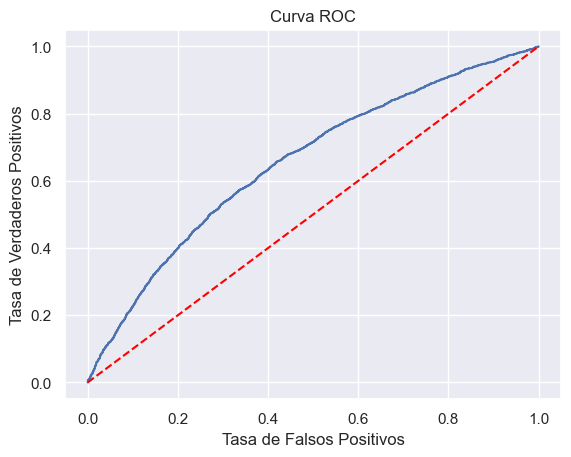

In [204]:
plt.plot(falsos_positivos, verdaderos_positivos) 
plt.plot(falsos_positivos, falsos_positivos, linestyle = '--', color = 'red') 
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')

In [205]:
# Maintenant, estimons l'aire sous la courbe ROC (AUC).

In [206]:
AUC = roc_auc_score(Reales_Predicciones['Tasa de Recuperacion 0'], Reales_Predicciones['Probabilidad Tasa de Recuperacion 0'])

L'AUC est de 65,45%, ce qui est acceptable. L'essentiel est que nous nous souvenions que nous utiliserons ce modèle comme une étape préliminaire pour estimer le LGD. Il est beaucoup plus important pour nous d'avoir une proportion élevée de taux de récupération classés comme supérieurs à zéro (47,76%) que de classer correctement les taux de récupération égaux à zéro (14,87%). C'est précisément ce que fait notre modèle. Rappelons-nous que dans la deuxième étape de notre modèle, où nous utiliserons la régression linéaire, certaines des observations peuvent encore être correctement classées comme des taux de récupération égaux à zéro.

In [208]:
AUC

0.654521896064191

# Sauvegarde du modèle

In [209]:
import pickle

In [211]:
pickle.dump(regresion, open('regresion.sav', 'wb')) 

In [212]:
pickle.dump(reglogistica_p_values, open('reglogistica_p_values.sav', 'wb')) 

# Modèle LGD : Régression Linéaire

In [213]:
# Recapitulemos. Dividimos el Modelo LGD en dos etapas:
# LGD0: Regresión Logística con la que predecimos si la tasa de recuperacion es igual o diferente de cero
# LGD1: Para las observaciones distintas de cero, utilizaremos un Modelo de Regresión Lineal Múltiple
# para predecir su tasa de recuperación

Tous les clients avec un taux de récupération = 0 ont été codés comme 1 dans la variable tasa_recuperacion_0. Par conséquent, les clients avec un taux de récupération différent de zéro, qui sont ceux qui nous intéressent dans la deuxième étape du modèle, sont codés comme 0 dans la variable mentionnée. Choisissons donc les données dont nous avons besoin :

In [215]:
datos_lgd1 = datos_defaults[datos_defaults['tasa_recuperacion_0'] == 0]

In [216]:
#Séparation des données d'entraînement et d'évaluation à partir de la base de données "datos_lgd1",
#c'est-à-dire celles qui ont un taux de récupération différent de zéro.

In [217]:
lgd1_independientes_entreno, lgd1_independientes_evaluacion, lgd1_dependiente_entreno, lgd1_dependiente_evaluacion = train_test_split(
    datos_lgd1.drop(['buenos_malos', 'tasa_recuperacion', 'tasa_recuperacion_0', 'FCC'], axis = 1), datos_lgd1['tasa_recuperacion'], test_size = 0.2, random_state = 99)

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [220]:
#Présélectionnons uniquement les variables indépendantes contenues dans la liste "nombres_variables".

In [221]:
lgd1_independientes_entreno = lgd1_independientes_entreno[nombres_variables]

In [222]:
# Ensuite, supprimons les variables dummies de référence de la liste "nombres_referencias".

In [223]:
lgd1_independientes_entreno = lgd1_independientes_entreno.drop(nombres_referencias, axis = 1)

Nous effectuons la régression linéaire. Notre modèle fonctionnera, mais nous n'aurons
pas les valeurs p pour déterminer quelles variables sont statistiquement significatives, 
ce qui, comme nous l'avons déjà mentionné, n'affecte pas la puissance prédictive du modèle. Définissons l'objet "regresionlgd1" en tant qu'instance de la classe "LinearRegression()".

In [225]:
regresionlgd1 = LinearRegression()

In [226]:
# Effectuons l'ajustement du modèle avec "lgd1_independientes_entreno" et "lgd1_dependiente_entreno".

In [227]:
regresionlgd1.fit(lgd1_independientes_entreno, lgd1_dependiente_entreno)

LinearRegression()

In [ ]:
# tableau des resultats

In [228]:
nombres_var_independientes = lgd1_independientes_entreno.columns.values
tabla_resultados = pd.DataFrame(columns = ['Variable Independiente'], data = nombres_var_independientes)
tabla_resultados['Coeficientes'] = np.transpose(regresionlgd1.coef_)
tabla_resultados.index = tabla_resultados.index + 1
tabla_resultados.loc[0] = ['Intercepto', regresionlgd1.intercept_]
tabla_resultados = tabla_resultados.sort_index()
# p_values = regresionlgd1.p
# p_values = np.append(np.nan, np.array(p_values))
# tabla_resultados['p_values'] = p_values.round(3)
tabla_resultados

Variable Independiente  Coeficientes
0                     Intercepto  3.796246e-01
1                  Casa_MORTGAGE -4.701315e-02
2                      Casa_NONE  6.875566e-02
3                       Casa_OWN -4.471792e-02
4                      Casa_RENT -4.967543e-02
5                  Proposito_car -6.487102e-03
6          Proposito_credit_card -3.873809e-03
7   Proposito_debt_consolidation -2.508568e-03
8          Proposito_educational  6.543699e-02
9     Proposito_home_improvement -4.794925e-03
10               Proposito_house -1.958400e-03
11      Proposito_major_purchase  2.107439e-04
12             Proposito_medical  6.490975e-04
13              Proposito_moving  1.193106e-02
14    Proposito_renewable_energy  2.342617e-02
15      Proposito_small_business -7.623313e-05
16            Proposito_vacation  3.005183e-03
17             Proposito_wedding  1.581432e-02
18                      Grados_A -6.990085e-02
19                      Grados_B -5.589742e-02
20                      Grados_C -4.136210e-02
21                      Grados_D -3.140528e-02
22                      Grados_E -1.600256e-02
23                      Grados_F -2.551995e-03
24                Estado_Lista_w  1.334538e-02
25     Verificacion_Not Verified  1.552172e-03
26  Verificacion_Source Verified -3.301034e-03
27                      term_num  3.493682e-04
28                emp_length_num  1.086946e-04
29                 meses_credito -7.556053e-04
30            meses_lineacredito -7.556053e-04
31                   funded_amnt -2.749279e-07
32                      int_rate -2.794624e-03
33                   installment -6.646312e-06
34                    annual_inc  8.321199e-08
35                           dti  1.428533e-04
36                   delinq_2yrs  1.509904e-03
37                inq_last_6mths  1.422079e-03
38        mths_since_last_delinq  7.864095e-06
39        mths_since_last_record -5.084699e-05
40                      open_acc -1.099424e-03
41                       pub_rec  4.009326e-03
42                     total_acc  3.948788e-04
43                acc_now_delinq  8.194916e-04
44              total_rev_hi_lim  2.764911e-07

Interprétation des Coefficients

Les coefficients des variables numériques ne reflètent pas s'ils appartiennent à une catégorie d'une variable indépendante d'origine ou non. Au lieu de cela, ils reflètent le changement d'unité dans la variable. Par exemple, en utilisant la variable int_rate, pour chaque point de pourcentage supplémentaire dans le taux d'intérêt, le taux de récupération diminuerait de 0,00279.

Pour les variables dummies : Casa_RENT : -4,967543e-02. Le fait que la personne habite dans une maison louée réduit le taux de récupération de 0,00496.

# Prédiction et évaluation de la deuxième étape du modèle LGD

In [ ]:
#Pour évaluer le modèle, nous appliquerons le modèle à notre base d'évaluation. 
#Nous utiliserons exactement les mêmes variables avec lesquelles nous avons construit
#le modèle, c'est-à-dire celles qui sont dans la liste "nombres_variables".

In [229]:
lgd1_independientes_evaluacion = lgd1_independientes_evaluacion[nombres_variables]

In [230]:
# Ensuite, nous supprimons les variables de référence.

In [231]:
lgd1_independientes_evaluacion = lgd1_independientes_evaluacion.drop(nombres_referencias, axis = 1)

In [232]:
# Nous pouvons effectuer la prédiction en utilisant la méthode "predict" sur notre modèle "regresionlgd1".

In [233]:
prediccion_lgd1 = regresionlgd1.predict(lgd1_independientes_evaluacion)

In [234]:
prediccion_lgd1

array([0.10358638, 0.129545  , 0.11218359, ..., 0.0760133 , 0.13188127,
       0.12282615])

In [235]:
#prediccion_lgd1 contient un tableau avec les prédictions du taux de récupération.
#Pour évaluer la qualité de nos prédictions, créons un tableau contenant les valeurs réelles et les prédictions.
#Avant de concaténer les données, nous devons réinitialiser les indices.
#Créons une variable temporaire pour la variable dépendante.


In [236]:
lgd1_dependiente_evaluacion_temp = lgd1_dependiente_evaluacion

In [237]:
lgd1_dependiente_evaluacion_temp = lgd1_dependiente_evaluacion_temp.reset_index(drop = True)

In [238]:
lgd1_dependiente_evaluacion_temp #Les valeurs réelles du taux de récupération

0       0.098983
1       0.141240
2       0.124247
3       0.040007
4       0.044483
5       0.117099
6       0.124489
7       0.000405
8       0.143018
9       0.123671
10      0.039600
11      0.093081
12      0.107277
13      0.119673
14      0.121060
15      0.128015
16      0.089594
17      0.040902
18      0.023685
19      0.164027
20      0.101667
21      0.088258
22      0.100027
23      0.100266
24      0.121429
25      0.018483
26      0.052877
27      0.119080
28      0.097567
29      0.052708
30      0.062194
31      0.130533
32      0.067870
33      0.134816
34      0.133294
35      0.109595
36      0.157108
37      0.134554
38      0.001476
39      0.134104
40      0.123187
41      0.319099
42      0.158573
43      0.102317
44      0.001035
45      0.187073
46      0.063714
47      0.107316
48      0.119948
49      0.054813
50      0.076970
51      0.130998
52      0.025232
53      0.054981
54      0.175562
55      0.024960
56      0.043762
57      0.167893
58      0.2993

In [239]:
#Une fois les indices réinitialisés, nous pouvons concaténer dans un tableau les 
#valeurs réelles du taux de récupération avec la prédiction que nous avons faite
#avec notre modèle. Nous estimons la corrélation qui existe entre les deux séries.

In [240]:
pd.concat([lgd1_dependiente_evaluacion_temp, pd.DataFrame(prediccion_lgd1)], axis = 1).corr()

tasa_recuperacion         0
tasa_recuperacion           1.000000  0.308502
0                           0.308502  1.000000

Une corrélation est un nombre entre -1 et 1 qui mesure la force de la relation entre deux séries de données. Une corrélation de 0,308502 est faible. Mais dans le contexte d'un modèle de LGD, c'est un nombre tout à fait acceptable. En fait, au-dessus de 0,6-0,7, vous devriez commencer à examiner vos données, car ce serait inhabituellement élevé.

In [242]:
#Maintenant, nous pouvons analyser la distribution entre les données réelles et 
#les prédictions du taux de récupération. Créons un graphique de distribution de
#la différence entre les deux séries.

C:\Users\IDEAPAD5\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: xlabel='tasa_recuperacion', ylabel='Density'>

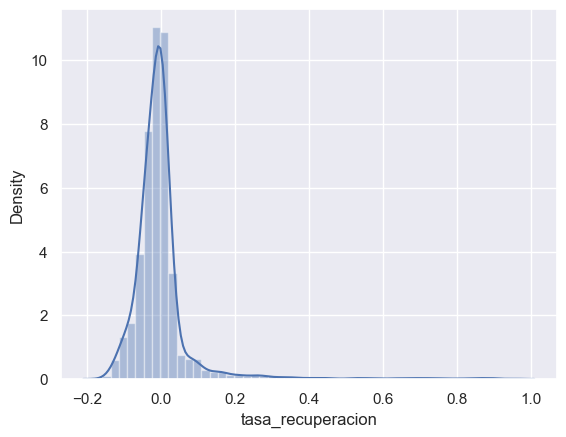

In [243]:
sns.distplot(lgd1_dependiente_evaluacion_temp - prediccion_lgd1)

In [244]:
#Nous observons un graphique qui ressemble à une distribution normale, où la plupart
#des résidus semblent être symétriquement distribués autour de zéro. De plus, zéro est 
#l'endroit où la plupart des résidus sont concentrés, nous pouvons donc dire que nous avons un bon modèle.

In [245]:
# Sauvegardons le modèle avec la méthode "dump" du module "pickle".

In [246]:
pickle.dump(regresionlgd1, open('regresionlgd1.sav', 'wb'))